In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
plt.rcParams['figure.dpi'] = 120

np.random.seed(0)

from PIL import Image
from sklearn.neighbors import KDTree
import colour

import tqdm
from elman_opt import ElmanNetwork, normalize, save, load

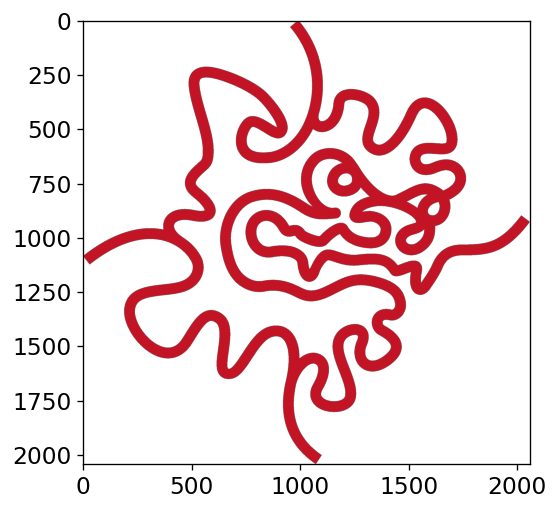

In [2]:
img = Image.open('/home/jack/Pictures/OIST/logo_shisa.tiff')

plt.imshow(img)
plt.show()

In [6]:
imgArr = np.array(img)[:,:,0]

imgArr[imgArr] = 1

# Convert to points

xArr, yArr = np.where(imgArr != 0)

xArr, yArr = xArr[::500], yArr[::500]

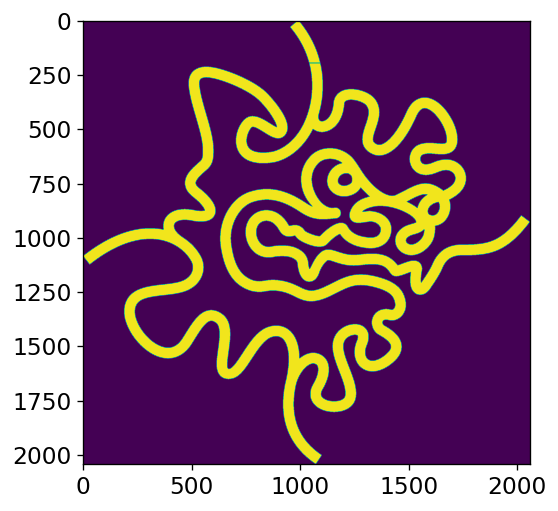

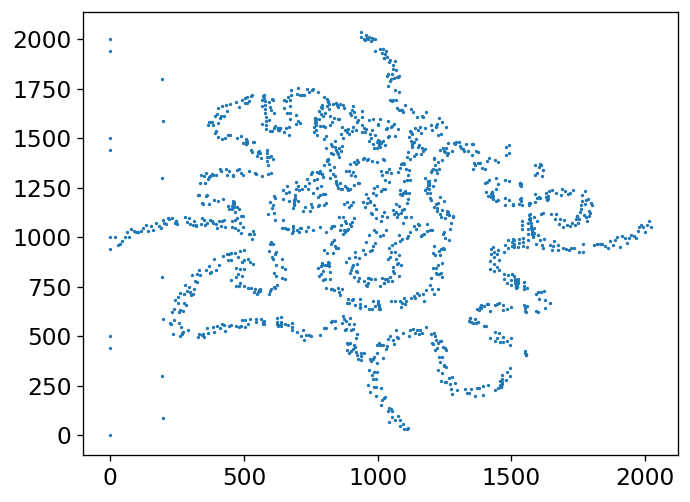

In [7]:
plt.imshow(imgArr)
plt.show()

plt.scatter(xArr, yArr, s=1)
plt.show()

In [8]:
# Order based on proximity

#kdTree = KDTree(np.array(list(zip(xArr, yArr))), leaf_size=40)

remainingPoints = list(zip(xArr, yArr))

orderedPoints = [(xArr[np.argmin(xArr)], yArr[np.argmin(xArr)])]
del remainingPoints[np.argmin(xArr)]


for i in tqdm.tqdm(range(len(xArr)-1)):
    dist = np.sum((np.array(remainingPoints) - orderedPoints[-1])**2, axis=-1)
    ind = np.argmin(dist)
    orderedPoints.append(remainingPoints[ind])
    del remainingPoints[ind]
    
orderedPoints = np.array(orderedPoints)

100%|█████████████████████| 1532/1532 [00:00<00:00, 3607.50it/s]


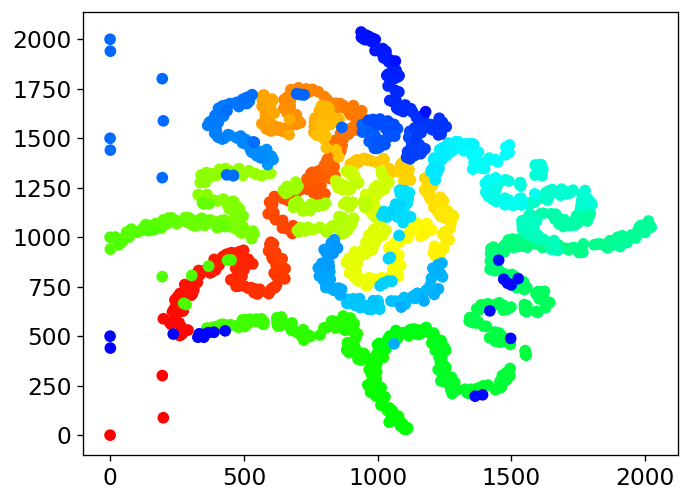

In [9]:
colourMap = colour.Color('Red').range_to(colour.Color('Blue'), len(orderedPoints))

colourMap = [str(s) for s in colourMap]

plt.scatter(orderedPoints[:,0], orderedPoints[:,1], c=colourMap)
plt.show()

In [10]:
numEpochs = 50000

model = ElmanNetwork(inputDim=2,
                     contextDim=30,
                     outputDim=2,
                     learningRate=.1)

inputArr = normalize(orderedPoints[:-1])
targetArr = normalize(orderedPoints[1:])
errorArr = np.zeros(numEpochs) # list to store errors

for epoch in tqdm.tqdm(range(numEpochs)):
    # Context and output
    contextArr, outputArr = model.forwardSequence(inputArr)
    errorArr[epoch]  = model.backwardSequence(inputArr, contextArr, outputArr, targetArr)
    model.updateParameters()
    
save(model, 'models/shisa.npz')

  0%|                                 | 0/50000 [00:00<?, ?it/s]<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 1d, C))
<string>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
 63%|█████████████▏       | 31415/50000 [15:27<09:08, 33.85it/s]


KeyboardInterrupt: 

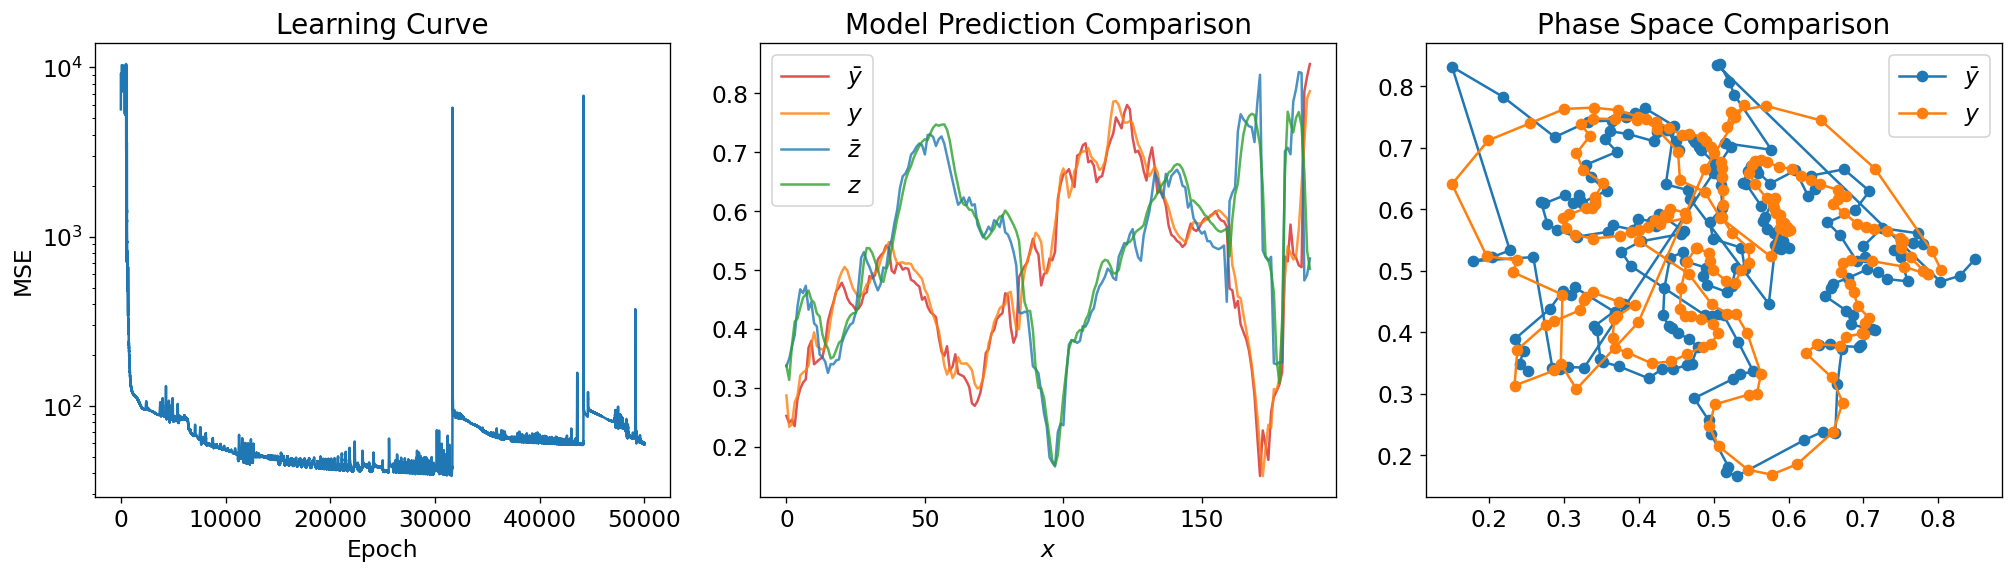

In [106]:
fig = plt.figure(figsize=(17,5))

ax = [None, None, None]
ax[0] = fig.add_subplot(1, 3, 1)

ax[0].plot(errorArr)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('MSE')
ax[0].set_yscale('log')
ax[0].set_title('Learning Curve')

ax[1] = fig.add_subplot(1, 3, 2)

ax[1].plot(targetArr[1:,0], alpha=.8, c='tab:red', label=r'$ \bar y $')
ax[1].plot(outputArr[1:,0], alpha=.8, c='tab:orange', label='$ y $')
ax[1].plot(targetArr[1:,1], alpha=.8, c='tab:blue', label=r'$ \bar z $')
ax[1].plot(outputArr[1:,1], alpha=.8, c='tab:green', label='$ z $')
ax[1].legend()
ax[1].set_xlabel('$x$')
ax[1].set_title('Model Prediction Comparison')

ax[2] = fig.add_subplot(1, 3, 3)

ax[2].plot(targetArr[1:,0], targetArr[1:,1], '-o', label=r'$\bar y$')
ax[2].plot(outputArr[1:,0], outputArr[1:,1], '-o', label=r'$y$')
ax[2].legend()
ax[2].set_title('Phase Space Comparison')

fig.tight_layout()

plt.show()